# Análise inicial de Modelos de Regressão com características específicamente Lineares

Inicialmente faremos uma análise preliminar dos dados da forma mais simples possível, isso significa que por enquanto não será feito transformações na escala das variáveis que serão submetidas ao modelo. Faremos apenas a transformação das colunas categóricas, já que os modelos de ML só aceitam colunas numéricas.

Será utilizado como método de avaliação preliminar o **DummyRegressor**, um modelo que apenas faz um chute da média ou mediana. Queremos saber se o modelo mais simples(com configurações padrão) consegue superar o DummyRegressor(que é um mero chute da média). Assim, vamos saber se vale a pena investir tempo e recursos computacionais nesse modelo, ou um modelo mais complexo.

In [1]:
# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    QuantileTransformer
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor
)

sns.set_theme(palette='bright')


In [2]:
# Importando os dados tratados
df = pd.read_parquet(DADOS_LIMPOS)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
# Pegando as colunas que vão sofrer transformações
col_target = ['median_house_value']
col_onehot = ['ocean_proximity']
col_ordinal = ['median_income_cat']

In [5]:
# Criando o nosso transformador
preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), col_onehot),
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), col_ordinal),
    ],
    remainder='passthrough'
)

In [6]:
X = df.drop(columns=col_target)
y = df[col_target]

In [7]:
target_transformer = PowerTransformer()

## O que será feito a partir daqui:
- Primeiro: Queremos saber se um modelo simples como o **LinearRegression** consegue se sair melhor do que um méro chute da média(DummyRegression).
- Segundo: Queremos saber se vale a pena aumentar a complexidade e recursos computacionais na transformação do nosso Target(variável alvo).

In [8]:
# Criando o dicionário de regressores
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_target': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },
}

In [9]:
# Treinando e validando os modelos do dicionário de regressores. Transformando os resultados em um DF.
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **modelo_etapas)
    for nome_modelo, modelo_etapas in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.014411,0.010113,-0.000081,-77516.042766,-96239.705692,0.024525
1,DummyRegressor,0.008069,0.007971,-0.000146,-75787.787194,-95217.629397,0.01604
2,DummyRegressor,0.005331,0.008106,-0.001737,-76753.598961,-96253.253947,0.013437
3,DummyRegressor,0.004895,0.0,-0.000101,-76837.804811,-95983.885799,0.004895
4,DummyRegressor,0.016186,0.0,-0.000114,-76617.245449,-96182.764729,0.016186
5,LinearRegression,0.181079,0.031946,0.682162,-39855.690921,-54254.958115,0.213026
6,LinearRegression,0.065493,0.014765,0.66999,-40272.565406,-54695.230224,0.080258
7,LinearRegression,0.064161,0.015866,0.649247,-42178.059246,-56955.988686,0.080027
8,LinearRegression,0.048321,0.03431,0.669873,-40806.492452,-55146.31876,0.082631
9,LinearRegression,0.031629,0.014136,0.669023,-40788.496555,-55331.351171,0.045765


In [10]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.009778,0.005238,-0.000436,-76702.495836,-95975.447913,0.015016
LinearRegression,0.078137,0.022205,0.668059,-40780.260916,-55276.769391,0.100341
LinearRegression_target,0.082409,0.022388,0.671185,-38909.258354,-55011.704371,0.104797


- Podemos observar que naturalmente o modelo mais complexo, que é o LinearRegression com transformação de Target demorou um pouco mais de tempo para finalizar.

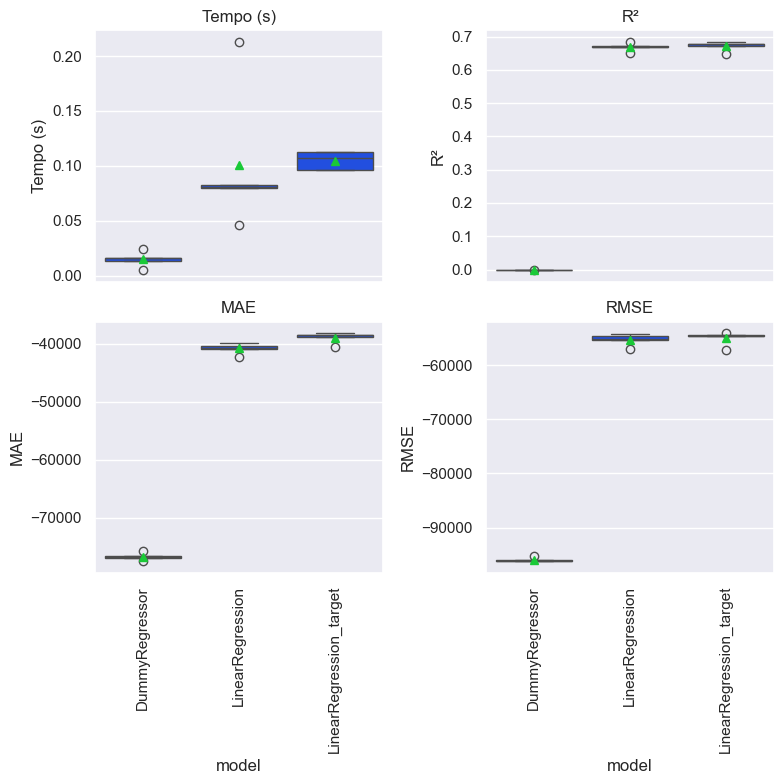

In [11]:
plot_comparar_metricas_modelos(df_resultados)

- No que diz respeito a transformação de target, a diferença em relação a esses dados, no quesito tempo foi mínima, e o ganho em performance em relação as métricas também foram pequenos, mas consideráveis.

## Explorando os tranformadores e introduzindo GridSearchCV

- Vamos implementar um novo transformador de Target para efeito de comparação. Já vimos anteriormente que aparentemente vale a pena investir em um transformador de Target, então nosso objetivo aqui é saber se o **PowerTransformer** é o mais adequado, ou se o **QuantileTransformer** se sai melhor.

In [12]:
# Grade de parâmetros dos transformadores
param_grid = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

# Função que constrói Pipeline com preprocessamento e regressor e executa o GridSearchCV
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
# Submetendo os dados ao modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [14]:
# O melhor parâmetro
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [15]:
# A melhor pontuação
grid_search.best_score_

np.float64(-54438.625311584285)

In [16]:
# Criando um DF com as colunas e seus respectivos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.453071
remainder__longitude,-0.293539
remainder__latitude,-0.286779
remainder__population_per_household,-0.279900
one_hot__ocean_proximity_NEAR BAY,-0.202450
one_hot__ocean_proximity_NEAR OCEAN,-0.059542
remainder__total_bedrooms,-0.000228
remainder__total_rooms,-0.000060
remainder__population,-0.000035
remainder__households,0.000853


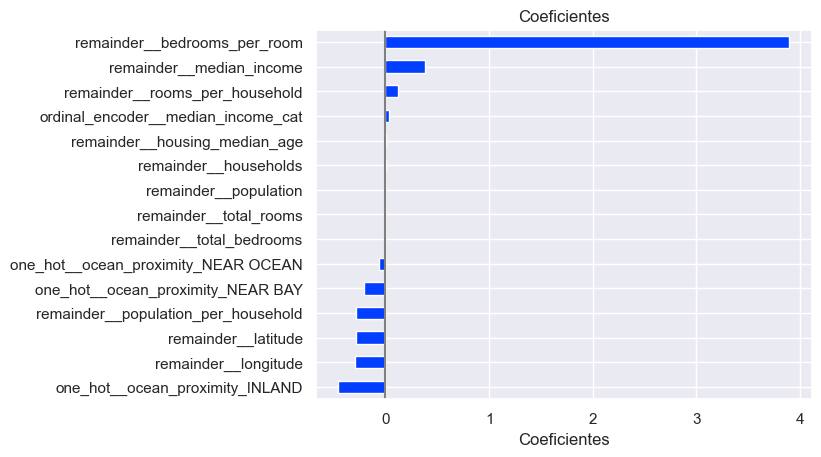

In [17]:
plot_coeficientes(coefs)

- Por algum motivo o modelo chegou a conclusão de que `bedrooms_per_room` é bastante importante para prever a variável alvo, pois deu a essa coluna um coeficiente bem alto em comparação as demais, mas será que essa variável é realmente TÃO importante assim ?

- Uma outra característica interessante são os coeficientes de algumas colunas que foram zerados. Além de alguns coeficientes negativos para coluna categórica que sofreu a transformação do **OneHotEncoder**; percebemos o que haviamos observado através dos gráficos e correlações, na medida que as casas se distanciam do oceano, o preço delas diminui.

In [18]:
# Recriando o dicionário de regressores para a nova análise
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_target_power': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },
    'LinearRegression_target_quantile': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [19]:
# Treinando e validando os modelos do dicionário de regressores. Transformando os resultados em um DF.
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **modelo_etapas)
    for nome_modelo, modelo_etapas in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.0,0.015451,-0.000081,-77516.042766,-96239.705692,0.015451
1,DummyRegressor,0.014359,0.010108,-0.000146,-75787.787194,-95217.629397,0.024467
2,DummyRegressor,0.009311,0.010997,-0.001737,-76753.598961,-96253.253947,0.020308
3,DummyRegressor,0.001617,0.016141,-0.000101,-76837.804811,-95983.885799,0.017758
4,DummyRegressor,0.0,0.015854,-0.000114,-76617.245449,-96182.764729,0.015854
5,LinearRegression,0.063629,0.015742,0.682162,-39855.690921,-54254.958115,0.07937
6,LinearRegression,0.053319,0.01601,0.66999,-40272.565406,-54695.230224,0.069329
7,LinearRegression,0.047828,0.031845,0.649247,-42178.059246,-56955.988686,0.079673
8,LinearRegression,0.047628,0.015837,0.669873,-40806.492452,-55146.31876,0.063466
9,LinearRegression,0.047561,0.01583,0.669023,-40788.496555,-55331.351171,0.063391


In [20]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005057,0.01371,-0.000436,-76702.495836,-95975.447913,0.018768
LinearRegression,0.051993,0.019053,0.668059,-40780.260916,-55276.769391,0.071046
LinearRegression_target_power,0.083091,0.021503,0.671185,-38909.258354,-55011.704371,0.104594
LinearRegression_target_quantile,0.067031,0.02224,0.678228,-38678.233791,-54419.511108,0.089271


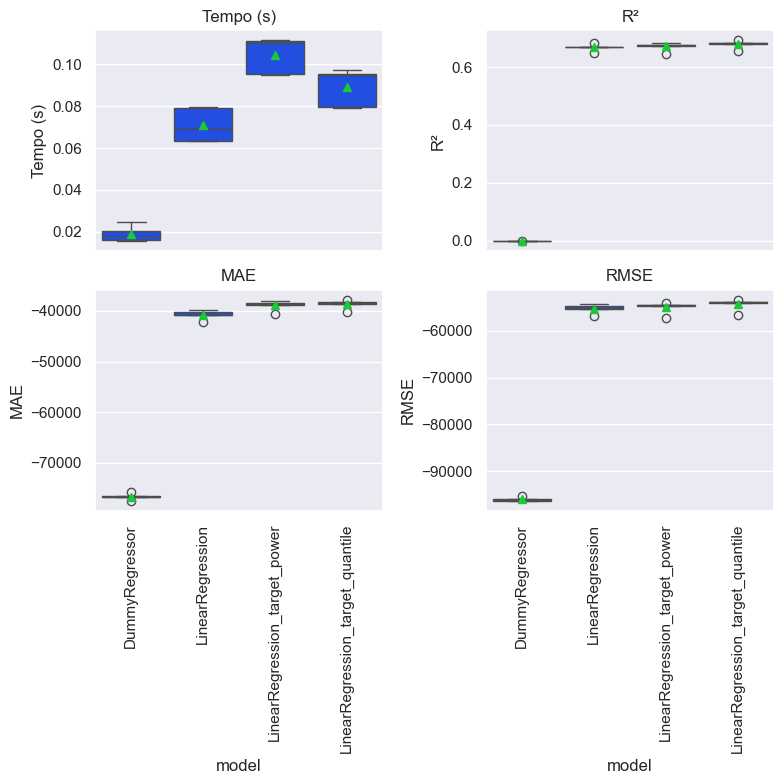

In [21]:
plot_comparar_metricas_modelos(df_resultados)

Em relação ao tempo de execução, ainda que o **LinearRegression_target_quantile** tenha um outlier por algum motivo, ele ainda tem praticamente o mesmo tempo de execução ou mais rápido que o **LinearRegression_target_power**, além de ter uma pequena melhora nas métricas de interesse.

Lembrando que todas essas análises de tempo de execução varia em relação a capacidade computacional de cada computador, da quantidade de programas que estão rodando juntos com esses scripts, entre outras.

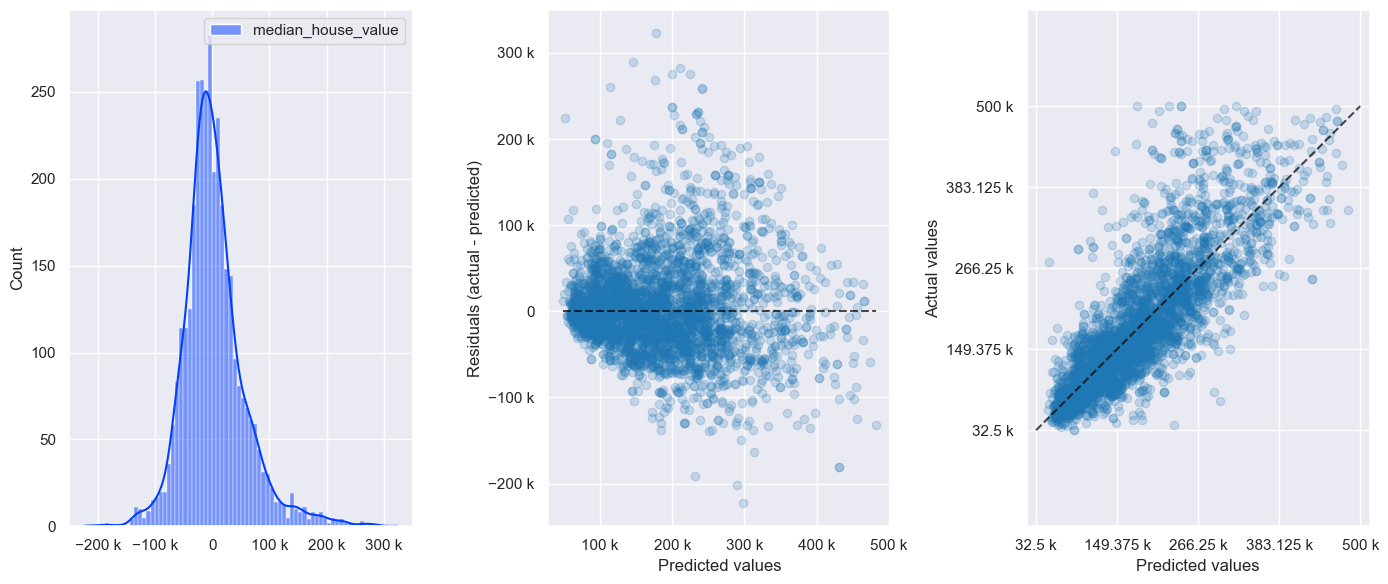

In [22]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.20, eng_formatter=True)

- O histograma possui uma assimetria positiva o que nos diz que o nosso modelo está errando mais para casas com peços mais altos, no segundo gráfico vemos isso com mais precisão onde o resíduo(erro) chega a praticamente 300.000, ou seja, hipotéticamente falando, uma casa que custa 500.000 o modelo está prevendo como custando 200.000. E no terceiro gráfico nós vemos quais são aproximadamente os valores reais e quais foram aproximadamente os valores previstos pelo modelo.